### 테스트 데이터셋 만들기
훈련하는게 아니므로 train, val은 생략.

,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr,NORM,MI,STTC,CD,HYP
0,9,18792.0,55.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-12-08 09:44:43,...,NaN,NaN,10,records100/00000/00009_lr,records500/00000/00009_hr,1,0,0,0,0
1,38,17076.0,40.0,0,NaN,72.0,2.0,0.0,CS-12 E,1985-02-15 11:48:22,...,NaN,NaN,10,records100/00000/00038_lr,records500/00000/00038_hr,1,0,0,0,0
2,40,19501.0,60.0,0,NaN,85.0,2.0,0.0,CS-12 E,1985-02-20 11:43:45,...,NaN,NaN,10,records100/00000/00040_lr,records500/00000/00040_hr,1,0,0,0,0
3,57,16063.0,26.0,0,NaN,93.0,2.0,0.0,CS-12 E,1985-06-06 11:32:43,...,NaN,NaN,10,records100/00000/00057_lr,records500/00000/00057_hr,1,0,0,0,0
4,59,19475.0,54.0,0,NaN,67.0,2.0,0.0,CS-12 E,1985-06-12 06:36:01,...,NaN,NaN,10,records100/00000/00059_lr,records500/00000/00059_hr,1,0,0,0,0


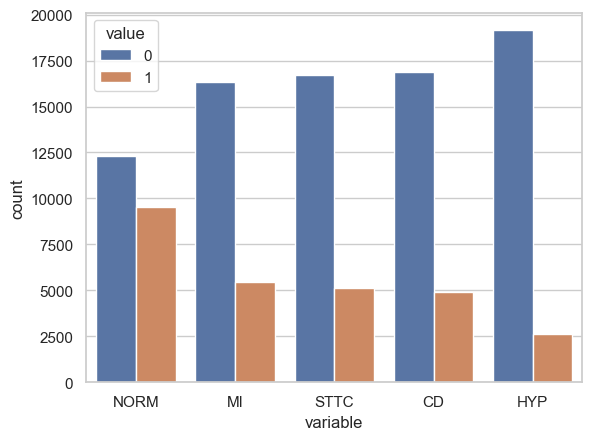

In [1]:
from torch.utils.data import DataLoader
from ver5_journal.common.data.ECG_Data import ECG_Data
from ver5_journal.common.data.create_final_data import create_final_data

final_data=create_final_data()

ECG_test = final_data[final_data['strat_fold'] == 10].reset_index(drop=True)

test_dataset=ECG_Data(ECG_test)
test_loader=DataLoader(test_dataset,batch_size=32, shuffle=True)
ECG_test.head()

### 테스트

In [5]:
from ver5_journal.common.network.BCResNets import BCResNets
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# 모델 순서 정의
sequence = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

num_models = len(sequence)

# 각 모델을 불러와 AUC 테스트를 수행하는 코드
best_models = []

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# 모델 입력 채널 수 정의
in_channel = 12

# 저장된 각 모델을 로드하여 리스트에 저장
for dd in sequence:
    model_path = f'../common/best_models/{dd}_model.pth'
    model = BCResNets(int(2 * 8), 1, in_channel).to(device)  # 모델 구조 동일하게 맞춰야 함
    # model.load_state_dict(torch.load(model_path, weights_only=True))
    model.load_state_dict(torch.load(model_path, weights_only=True))
    model.eval()
    best_models.append(model)

In [6]:
from sklearn.metrics import roc_auc_score, accuracy_score

# 임계값을 0.05씩 증가시키며 테스트
thresholds = np.arange(0.2, 1.0, 0.1)
loss_fn = torch.nn.BCELoss()

for threshold in thresholds:
    print("=====================================================================")
    print(f'\nTesting Serialized Model Pipeline with Threshold: {threshold:.2f}')
    y_true = []
    y_pred = []
    total_test_loss = 0  # 테스트 전체 Loss 저장

    # 테스트 데이터셋을 연결된 모델에 사용
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            
            # 각 데이터 포인트별로 모든 클래스에 대한 예측값을 저장하기 위한 리스트
            batch_predictions = []
            batch_loss = 0  # 배치에 대한 Loss 저장
            
            # 각 분류기에 대해 예측값을 얻음 (모델을 순차적으로 실행)
            for idx, model in enumerate(best_models):
                output = model(data)  # 각 모델이 배치에 대한 예측값을 출력 (배치 크기만큼의 값 반환)
                output = torch.sigmoid(output).squeeze(-1)  # Sigmoid 함수 적용 후 배치 크기 유지

                # 실제 레이블에서 해당 클래스만 선택
                label_data = label[:, idx].float()  # 각 클래스에 대한 실제 레이블
                loss = loss_fn(output, label_data)  # 각 클래스에 대한 Loss 계산
                batch_loss += loss.item()  # 배치에 대한 Loss 누적

                # 각 모델의 출력이 임계값을 넘으면 1, 아니면 0으로 설정
                predictions = (output.detach().cpu().numpy() > threshold).astype(int)
                batch_predictions.append(predictions)

            # 배치에 대한 평균 Loss 계산
            batch_loss /= len(best_models)  # 각 모델별로 계산된 Loss의 평균
            total_test_loss += batch_loss  # 배치별 Loss를 전체 테스트 Loss에 누적
            
            # 모든 클래스에 대한 예측값을 저장
            batch_predictions = np.array(batch_predictions)  # (num_models, batch_size) 형태
            batch_predictions = batch_predictions.T  # (batch_size, num_models) 형태로 변환

            # 각 샘플에 대해 예측값과 실제값 저장
            y_true.extend(label.cpu().numpy())  # 실제값 (멀티레이블)
            y_pred.extend(batch_predictions)    # 예측값 (멀티레이블)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # 각 클래스별 ROC-AUC 점수 계산
    for i, label_name in enumerate(sequence):
        auc = roc_auc_score(y_true[:, i], y_pred[:, i])
        print(f'Label: {label_name}, AUC: {auc:.4f}')
    
    # 멀티레이블 전체의 Accuracy 계산
    total_accuracy = accuracy_score(y_true, y_pred)
    avg_test_loss = total_test_loss / len(test_loader)  # 전체 테스트에 대한 평균 Loss
    print(f'Overall accuracy with threshold {threshold:.2f}: {total_accuracy:.4f}')
    print(f'Average Test Loss with threshold {threshold:.2f}: {avg_test_loss:.4f}')
    print("=====================================================================")



Testing Serialized Model Pipeline with Threshold: 0.20
Label: NORM, AUC: 0.8313
Label: MI, AUC: 0.8298
Label: STTC, AUC: 0.8351
Label: CD, AUC: 0.6937
Label: HYP, AUC: 0.7915
Overall accuracy with threshold 0.20: 0.2002
Average Test Loss with threshold 0.20: 0.3149

Testing Serialized Model Pipeline with Threshold: 0.30
Label: NORM, AUC: 0.8534
Label: MI, AUC: 0.8514
Label: STTC, AUC: 0.8530
Label: CD, AUC: 0.8045
Label: HYP, AUC: 0.8159
Overall accuracy with threshold 0.30: 0.3717
Average Test Loss with threshold 0.30: 0.3155

Testing Serialized Model Pipeline with Threshold: 0.40
Label: NORM, AUC: 0.8617
Label: MI, AUC: 0.8254
Label: STTC, AUC: 0.8582
Label: CD, AUC: 0.8437
Label: HYP, AUC: 0.8313
Overall accuracy with threshold 0.40: 0.4941
Average Test Loss with threshold 0.40: 0.3150

Testing Serialized Model Pipeline with Threshold: 0.50
Label: NORM, AUC: 0.8645
Label: MI, AUC: 0.8003
Label: STTC, AUC: 0.8415
Label: CD, AUC: 0.8466
Label: HYP, AUC: 0.8093
Overall accuracy with t

In [8]:
from sklearn.metrics import roc_auc_score, accuracy_score
import torch
import numpy as np

# 임계값을 0.5로 고정
threshold = 0.5
loss_fn = torch.nn.BCELoss()

print("=====================================================================")
print(f'\nTesting Serialized Model Pipeline with Threshold: {threshold:.2f}')
y_true = []
y_pred = []
total_test_loss = 0  # 테스트 전체 Loss 저장
incorrect_samples = []  # 틀린 샘플 저장 리스트

# 테스트 데이터셋을 연결된 모델에 사용
with torch.no_grad():
    for data, label in test_loader:
        data, label = data.to(device), label.to(device)
        
        # 각 데이터 포인트별로 모든 클래스에 대한 예측값을 저장하기 위한 리스트
        batch_predictions = []
        batch_loss = 0  # 배치에 대한 Loss 저장
        
        # 각 분류기에 대해 예측값을 얻음 (모델을 순차적으로 실행)
        for idx, model in enumerate(best_models):
            output = model(data)  # 각 모델이 배치에 대한 예측값을 출력 (배치 크기만큼의 값 반환)
            output = torch.sigmoid(output).squeeze(-1)  # Sigmoid 함수 적용 후 배치 크기 유지

            # 실제 레이블에서 해당 클래스만 선택
            label_data = label[:, idx].float()  # 각 클래스에 대한 실제 레이블
            loss = loss_fn(output, label_data)  # 각 클래스에 대한 Loss 계산
            batch_loss += loss.item()  # 배치에 대한 Loss 누적

            # 각 모델의 출력이 임계값을 넘으면 1, 아니면 0으로 설정
            predictions = (output.detach().cpu().numpy() > threshold).astype(int)
            batch_predictions.append(predictions)

        # 배치에 대한 평균 Loss 계산
        batch_loss /= len(best_models)  # 각 모델별로 계산된 Loss의 평균
        total_test_loss += batch_loss  # 배치별 Loss를 전체 테스트 Loss에 누적
        
        # 모든 클래스에 대한 예측값을 저장
        batch_predictions = np.array(batch_predictions)  # (num_models, batch_size) 형태
        batch_predictions = batch_predictions.T  # (batch_size, num_models) 형태로 변환

        # 각 샘플에 대해 예측값과 실제값 저장 및 틀린 샘플 확인
        for i in range(len(label)):
            true_values = label.cpu().numpy()[i]  # 실제값
            predicted_values = batch_predictions[i]  # 예측값

            # 예측값이 실제값과 다를 때
            if not np.array_equal(true_values, predicted_values):
                incorrect_samples.append((true_values, predicted_values))
                print(f"Sample {i}: True - {true_values}, Predicted - {predicted_values}")
            
            # 예측값과 실제값을 리스트에 저장
            y_true.append(true_values)
            y_pred.append(predicted_values)

# 성능 평가
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# 각 클래스별 ROC-AUC 점수 계산
for i, label_name in enumerate(sequence):
    auc = roc_auc_score(y_true[:, i], y_pred[:, i])
    print(f'Label: {label_name}, AUC: {auc:.4f}')

# 멀티레이블 전체의 Accuracy 계산
total_accuracy = accuracy_score(y_true, y_pred)
avg_test_loss = total_test_loss / len(test_loader)  # 전체 테스트에 대한 평균 Loss
print(f'Overall accuracy with threshold {threshold:.2f}: {total_accuracy:.4f}')
print(f'Average Test Loss with threshold {threshold:.2f}: {avg_test_loss:.4f}')
print("=====================================================================")


Testing Serialized Model Pipeline with Threshold: 0.50
Sample 1: True - [1. 0. 0. 0. 0.], Predicted - [0 0 0 0 0]
Sample 2: True - [0. 0. 0. 1. 0.], Predicted - [1 0 0 0 0]
Sample 3: True - [0. 0. 0. 0. 0.], Predicted - [0 1 0 1 0]
Sample 4: True - [0. 1. 1. 1. 1.], Predicted - [0 0 1 1 1]
Sample 9: True - [0. 1. 0. 1. 0.], Predicted - [0 0 1 1 0]
Sample 10: True - [0. 1. 0. 0. 0.], Predicted - [0 1 0 1 0]
Sample 11: True - [0. 1. 1. 0. 1.], Predicted - [0 0 1 1 1]
Sample 12: True - [0. 1. 0. 0. 0.], Predicted - [1 0 0 0 0]
Sample 14: True - [0. 0. 1. 0. 0.], Predicted - [0 1 1 1 0]
Sample 17: True - [0. 1. 0. 0. 0.], Predicted - [0 0 0 0 0]
Sample 23: True - [0. 0. 1. 0. 0.], Predicted - [0 0 0 0 0]
Sample 26: True - [0. 0. 1. 0. 0.], Predicted - [0 0 1 1 0]
Sample 27: True - [0. 0. 1. 1. 0.], Predicted - [1 0 0 0 0]
Sample 30: True - [0. 1. 0. 1. 0.], Predicted - [0 0 0 1 0]
Sample 31: True - [0. 1. 0. 0. 0.], Predicted - [0 1 0 1 1]
Sample 8: True - [1. 0. 0. 0. 0.], Predicted - [0